# Core idea

![DDPM Diagram](./data/DDPM.png)

Start from image $x_0$ and add noise to it, step by step:

<!-- Let $x_t = \beta_t x_{t-1} + \mathcal{N} (0, \sigma_t I)$ -->

$$
x_t \;=\; \sqrt{1-\beta_t}\; x_{t-1} \;+\; \sqrt{\beta_t}\; \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0, I),
$$
where $\beta_t \in (0, 1)$ is the noise variance at step $t$.

$\beta_t$ is noise schedule, a function $[0,\dots,T] \rightarrow R$



In [ ]:
#| echo: false
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_sample_image():
    import requests
    from io import BytesIO
    url = f"https://fastly.picsum.photos/id/837/256/256.jpg?hmac=ngYz7lq0_K-F_mVHKUBO0pAfpZUnMbCrUqE6ViE4W1o"
    response = requests.get(url, timeout=10)
    if response.ok and 'image' in response.headers.get('Content-Type', ''):
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return img
    else:
        raise ValueError("Invalid image response from the server.")

img = load_sample_image()
x0 = np.asarray(img).astype(np.float32) / 255.0

timesteps = 6
betas = np.linspace(0.03, 0.2, timesteps)
sigmas = np.linspace(0.08, 0.35, timesteps)
noised_imgs = [x0]

last_xt = x0
for i in range(timesteps - 1):
    noise = np.random.normal(loc=betas[i] * last_xt, scale=sigmas[i], size=x0.shape)
    xt = last_xt + noise
    xt = np.clip(xt, 0, 1)
    noised_imgs.append(xt)
    last_xt = xt

fig, axs = plt.subplots(1, timesteps, figsize=(4*timesteps, 4))
for i, (ax, img_step) in enumerate(zip(axs, noised_imgs)):
    if i == 0:
        ax.set_title("Original $x_0$")
    else:
        ax.set_title(f"Step {i}")
    ax.imshow(img_step)
    ax.axis('off')
plt.tight_layout()
plt.show()


It is important here that $x_t$ is conditionally independent of $x_{t-2}$ given $x_{t-1}$:
 
$$
q(x_t \mid x_{t-1}, x_{t-2}) = q(x_t \mid x_{t-1})
$$

In other words, we've defined a Markov chain.

We can derive the distribution of $q(x_t|x_{0})$.

Define $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$.

It is easy to see that $x_t \mid x_{t-2}$ is Gaussian:

$$
x_t \;=\; \sqrt{\alpha_t}\, x_{t-1} \;+\; \sqrt{1-\alpha_t}\, \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0, I).
$$

Using $x_{t-1} \;=\; \sqrt{\alpha_{t-1}}\, x_{t-2} \;+\; \sqrt{1-\alpha_{t-1}}\, \varepsilon_{t-1}$, we substitute to get
$$
x_t \;=\; \sqrt{\alpha_t \alpha_{t-1}}\, x_{t-2}
\;+\; \sqrt{\alpha_t(1-\alpha_{t-1})}\, \varepsilon_{t-1}
\;+\; \sqrt{1-\alpha_t}\, \varepsilon_t,
\quad \varepsilon_{t-1}, \varepsilon_t \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0, I).
$$

Therefore,
$$
x_t \mid x_{t-2} \;\sim\; \mathcal{N}\!\big(\sqrt{\alpha_t \alpha_{t-1}}\, x_{t-2},\; (1 - \alpha_t \alpha_{t-1})\, I\big),
$$

$$
\boxed{ \; q(x_t \mid x_0) \;=\; \mathcal{N}\!\big(\sqrt{\bar{\alpha}_t}\, x_0,\; (1-\bar{\alpha}_t)\, I\big) \; }.
$$

A commonly used reparameterization for sampling directly from $q(x_t \mid x_0)$ is
$$
x_t \;=\; \sqrt{\bar{\alpha}_t}\, x_0 \;+\; \sqrt{1-\bar{\alpha}_t}\, \varepsilon,\quad \varepsilon \sim \mathcal{N}(0, I).
$$


## Diffusion model as a special case of VAE

If you let $z=x_T$

We can see now that our procedure implements an encoder.

$$
q(z\mid x_0)\;= q(x_T|x_0) = \;\mathcal{N}\!\big(\sqrt{\bar{\alpha}_T}\,x_0,\; (1-\bar{\alpha}_T)\,I\big).
$$

so our encoder is basically a fixed function 
$$
x_0 \rightarrow (\sqrt{\bar\alpha_T} x_0, 1 - \bar\alpha_T)
$$

that outputs parameters of our gaussian.


So we can expect we are going to have the same kind of problem with our decoder.

## Decoder


$$
q(x_{t-1}|x_{t})
$$

What do we know about it?

We know that  $  x_{t-1} | (x_t,x_0)$ is Gaussian:






### $  x_{t-1} | (x_t,x_0)$ is Gaussian

1) Given $x_0$, the previous state is Gaussian:
$$
 x_{t-1}\mid x_0 \sim \mathcal{N}\!\big(\sqrt{\bar\alpha_{t-1}}\,x_0,\; (1-\bar\alpha_{t-1})I\big).
 $$

2) The forward step is linear-Gaussian:
$$
x_t \;=\; \sqrt{\alpha_t}\,x_{t-1} \;+\; \sqrt{1-\alpha_t}\,\varepsilon_t,\quad \varepsilon_t\sim\mathcal{N}(0,I),
$$
and $\varepsilon_t$ is independent of $x_{t-1}$ given $x_0$.

Write
$$
\begin{bmatrix} x_{t-1} \\ x_t \end{bmatrix}
=
\underbrace{\begin{bmatrix} I & 0 \\ \sqrt{\alpha_t}\,I & \sqrt{1-\alpha_t}\,I \end{bmatrix}}_{A}
\begin{bmatrix} x_{t-1} \\ \varepsilon_t \end{bmatrix},
$$
where $\begin{bmatrix} x_{t-1} \\ \varepsilon_t \end{bmatrix}\mid x_0$ is Gaussian (block-diagonal covariance). A linear transform of a Gaussian is Gaussian, so $(x_{t-1},x_t)\mid x_0$ is jointly Gaussian.

3) A basic Gaussian fact: if $\begin{bmatrix} U \\ V \end{bmatrix}$ is jointly Gaussian, then $U\mid V$ is Gaussian. Therefore
$$
q(x_{t-1}\mid x_t, x_0)\ \text{is Gaussian.}
$$

### The marginal reverse transition is not Gaussian

  $$
  q(x_{t-1}\mid x_t) \;=\; \int q(x_{t-1}\mid x_t,x_0)\;q(x_0\mid x_t)\,dx_0
  $$

## DDPM modeling choice

Approximate the reverse process as Gaussian:

$$
  p_\theta(x_{t-1}\mid x_t)=\mathcal{N}\!\big(\mu_\theta(x_t,t),\;\sigma_t^2 I\big),
$$
  with our decoder
$$
  \mu_\theta(x_t,t)=\frac{1}{\sqrt{\alpha_t}}\!\left(x_t-\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\;\varepsilon_\theta(x_t,t)\right),
  \qquad
  \sigma_t^2\in\{\beta_t,\;\tilde\beta_t\}.
$$

The intuition behind this is just having a denoising neural network $\epsilon_\theta(x_t,t)$.

Recover the noise that was applied to an input image and remove it.

## Deriving optimization objective in VAE-like manner


### ELBO
We lower-bound $\log p_\theta(x_0)$ with the standard variational bound using our fixed encoder $q$:
$$
\log p_\theta(x_0)\;\ge\;
\mathbb{E}_{q(x_{1:T}\mid x_0)}\!\big[\log p_\theta(x_{0:T})-\log q(x_{1:T}\mid x_0)\big].
$$
This decomposes into
$$
-\text{ELBO}
=\underbrace{\mathrm{KL}\big(q(x_T\mid x_0)\,\|\,p(x_T)\big)}_{L_T}
+\sum_{t=2}^{T}\underbrace{\mathbb{E}_{q(x_t\mid x_0)}\!\big[\mathrm{KL}\big(q(x_{t-1}\mid x_t,x_0)\,\|\,p_\theta(x_{t-1}\mid x_t)\big)\big]}_{L_{t-1}}
+\underbrace{\mathbb{E}_{q(x_1\mid x_0)}\!\big[-\log p_\theta(x_0\mid x_1)\big]}_{L_0}.
$$

Closed forms used in the KLs:
$$
q(x_T\mid x_0)=\mathcal{N}\big(\sqrt{\bar\alpha_T}x_0,(1-\bar\alpha_T)I\big),
$$
$$
q(x_{t-1}\mid x_t,x_0)=\mathcal{N}\big(\tilde\mu_t(x_t,x_0),\tilde\beta_t I\big),\quad
\tilde\beta_t=\frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\,\beta_t,
$$
$$
\tilde\mu_t(x_t,x_0)=\frac{\sqrt{\bar\alpha_{t-1}}\,\beta_t}{1-\bar\alpha_t}\,x_0
+\frac{\sqrt{\alpha_t}\,(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}\,x_t.
$$

### Parameterization for the reverse mean
Instead of predicting $x_0$ directly, predict noise $\varepsilon_\theta(x_t,t)$ and set
$$
\mu_\theta(x_t,t)=\frac{1}{\sqrt{\alpha_t}}\!\left(x_t-\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\;\varepsilon_\theta(x_t,t)\right).
$$
With this choice and fixed $\sigma_t^2$ (e.g., $\sigma_t^2=\tilde\beta_t$ or $\beta_t$), each KL term $L_{t-1}$ reduces to a weighted MSE between true noise and predicted noise.

### “Simplified” DDPM objective
Sample $t\sim\mathcal{U}\{1,\dots,T\}$, $x_0\sim p_{\text{data}}$, $\varepsilon\sim\mathcal{N}(0,I)$, form
$$
x_t=\sqrt{\bar\alpha_t}\,x_0+\sqrt{1-\bar\alpha_t}\,\varepsilon,
$$
and minimize
$$
\mathcal{L}_{\text{simple}}
=\mathbb{E}_{t,x_0,\varepsilon}\Big[\;\|\varepsilon-\varepsilon_\theta(x_t,t)\|_2^2\;\Big].
$$
This objective is proportional to (and upper-bounds) the negative ELBO up to constants when using the above $\mu_\theta$ and fixed $\sigma_t^2$. In practice one may use per-step weights or keep the uniform average; both optimize the same variational target up to a $t$-dependent constant.


Notes:
- $L_T$ matches $q(x_T\mid x_0)$ to the standard normal prior.
- $L_{t-1}$ encourages $p_\theta(x_{t-1}\mid x_t)$ to match the exact Gaussian posterior $q(x_{t-1}\mid x_t,x_0)$.
- $L_0$ is a reconstruction term; often Gaussian likelihood with fixed variance or implicitly handled by the noise-prediction parameterization above.



# Demo: simple 2D diffusion

In [17]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

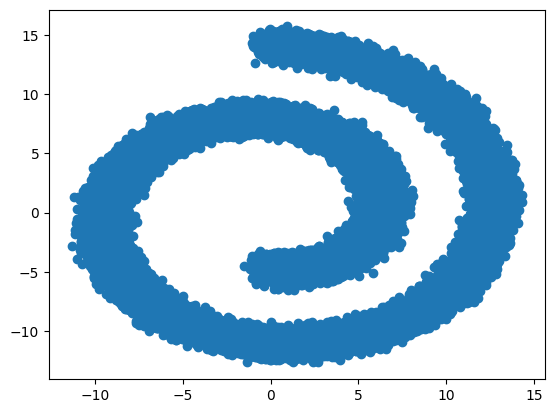

In [19]:
visualize_q1_dataset()

In [ ]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, all_samples

In [ ]:
import torch

def timestep_embedding(timesteps, dim, max_period=10000):
    device = timesteps.device
    base_dtype = timesteps.dtype if timesteps.dtype.is_floating_point else torch.float32
    half = dim // 2
    freqs = torch.exp(
        -torch.log(torch.tensor(float(max_period), device=device, dtype=base_dtype))
        * torch.arange(0, half, device=device, dtype=base_dtype)
        / half
    )
    args = timesteps.to(device=device, dtype=torch.float32)[:, None] * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb


## An implementation of DDPM denoiser (UNet)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.temb_channels = temb_channels
        self.conv_1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm_1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.act = nn.SiLU()
        self.linear = nn.Linear(temb_channels, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm_2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv_3 = nn.Conv2d(in_channels, out_channels, 1)
        
    def forward(self, x, temb):
        h = self.conv_1(x)
        h = self.norm_1(h)
        h = self.act(h)
        temb = self.linear(temb)
        h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
        h = self.conv_2(h)
        h = self.norm_2(h)
        h = self.act(h)
        if self.in_channels != self.out_channels:
            x = self.conv_3(x)
        return x + h


class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)
        
    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[32, 64, 128, 256, 512], blocks_per_dim=2):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims
        self.blocks_per_dim = blocks_per_dim
        self.temb_channels = hidden_dims[0] * 4
        self.hidden_dims_reversed = hidden_dims[::-1]

        self.temb_linear = nn.Sequential(
            nn.Linear(hidden_dims[0], self.temb_channels),
            nn.SiLU(),
            nn.Linear(self.temb_channels, self.temb_channels)
        )

        self.first_conv = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)

        skip_channels = [self.hidden_dims[0]]
        prev_ch = self.hidden_dims[0]
        self.downs = nn.ModuleList()
        for i in range(len(hidden_dims)):
            for _ in range(blocks_per_dim):
                self.downs.append(ResidualBlock(prev_ch, hidden_dims[i], self.temb_channels))
                prev_ch = hidden_dims[i]
            if i != len(hidden_dims) - 1:
                skip_channels.append(hidden_dims[i])
                self.downs.append(Downsample(hidden_dims[i]))
            
        self.intermediate_block_1 = ResidualBlock(hidden_dims[-1], hidden_dims[-1], self.temb_channels)
        self.intermediate_block_2 = ResidualBlock(hidden_dims[-1], hidden_dims[-1], self.temb_channels)

        self.ups = nn.ModuleList()
        for i, hidden_dim in enumerate(reversed(self.hidden_dims)):
            for j in range(blocks_per_dim + 1):
                in_ch = prev_ch + skip_channels[-1] if j == 0 else prev_ch
                self.ups.append(ResidualBlock(in_ch, hidden_dim, self.temb_channels))
                prev_ch = hidden_dim
            skip_channels.pop()
            if (i != len(hidden_dims) - 1): 
                self.ups.append(Upsample(prev_ch))

        self.groupnorm = nn.GroupNorm(num_groups=8, num_channels=hidden_dims[0])
        self.act = nn.SiLU()
        self.final_conv = nn.Conv2d(hidden_dims[0], in_channels, 3, padding=1)
    
    def forward(self, x, t):
        temb = timestep_embedding(t, self.hidden_dims[0])
        temb = self.temb_linear(temb)
        h = self.first_conv(x)
        hs = [h]
        for down in self.downs:
            if isinstance(down, Downsample):
                h = down(h)
                hs.append(h)
            else:
                h = down(h, temb)
        h = self.intermediate_block_1(h, temb)
        h = self.intermediate_block_2(h, temb)

        need_skip = True
        for up in self.ups:
            if isinstance(up, Upsample):
                h = up(h)
                need_skip = True
            else:
                if need_skip:
                    h = up(torch.cat([h, hs.pop()], dim=1), temb)
                    need_skip = False
                else:
                    h = up(h, temb)
            
        h = self.groupnorm(h)
        h = self.act(h)
        out = self.final_conv(h)
        return out


It has some modificitions to the original U-Net implementation.

1. **Time conditioning**


We accept a timestamp $t$, we use a fixed (non-learnable) positional encoding (`timestep_embedding` function) (just like original Transformer does).

We pass it through MLP

We use the result in **each** residual block by adding a learnable bias to each resulting feature map.

I think of it as "telling" each block how much noise remain and how to process features at that timestamp.

Each block has its own projection (just a linear layer that takes time embedding to the number of feature maps in this residual block), so different resolutions can use time information differently.

2. **GroupNorm**

BatchNorm depends on batch statistics; diffusion training often uses small batches and per-sample noise/timestep variation, which makes BN unstable.

GroupNorm is batch-size agnostic and consistent across timesteps/resolutions.

3. **SiLU**

SiLU (a.k.a. Swish) has smooth, nonzero gradients for negative inputs and tends to work better in deep generative models.

------------------


Apart from that, everything else is pretty much the same. The core ideas behind UNet:

1. An encoder-decoder architecture. Down and up paths -- that's where the "U" comes from

2. Down path: residual block (increase the number of channels) + downsample (reduce HxW by a certain fixed factor)

3. Some "intermediate" stuff: (couple of residual block with the same in/out number of channels).

4. Up path: residual block **with skip connections from the corresponding blocks in the encoder** (decrease the number of channels) + upsample (linear interpolation to a higher HxW)

Those skip connections from the encoder to decoder is probably the most interesting part.

Seems they carry high-frequency/local detail from early layers directly to matching-resolution layers in the decoder, which:

- Preserves spatial detail lost during downsampling.
- Makes optimization easier by providing short gradient paths.
- Lets the decoder fuse global context (from the bottleneck) with precise local features.


In [41]:
m = UNet(in_channels=3)
x = torch.randn(2, 3, 64, 64)
t = torch.randint(0, 1000, (2,))
y = m(x, t)
assert y.shape == x.shape

In [48]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

T = 1000
betas = torch.linspace(1e-4, 0.02, T, dtype=torch.float32, device=device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
alpha_bars_prev = torch.cat([alpha_bars.new_ones(1), alpha_bars[:-1]], dim=0)
sqrt_alpha_bars = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)
posterior_variance = torch.clamp(posterior_variance, min=1e-20)

def extract(a, t, x_shape):
    return a.gather(0, t).view(-1, *([1] * (len(x_shape) - 1)))

model = UNet(in_channels=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

epochs = 20
global_step = 0
model.train()
for epoch in range(epochs):
    loop = tqdm(train_loader, desc=f'epoch {epoch+1}/{epochs}', leave=False)
    for x0, _ in loop:
        x0 = x0.to(device)
        b = x0.size(0)
        t = torch.randint(0, T, (b,), device=device, dtype=torch.long)
        noise = torch.randn_like(x0)
        xt = extract(sqrt_alpha_bars, t, x0.shape) * x0 + extract(sqrt_one_minus_alpha_bars, t, x0.shape) * noise
        pred_noise = model(xt, t)
        loss = nn.functional.mse_loss(pred_noise, noise)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        global_step += 1
        loop.set_postfix(loss=float(loss.item()))
    os.makedirs('checkpoints', exist_ok=True)
    torch.save({'model': model.state_dict(), 'epoch': epoch + 1, 'step': global_step}, f'checkpoints/unet_epoch_{epoch+1}.pt')

@torch.no_grad()
def sample(model, num_images=64):
    model.eval()
    x = torch.randn(num_images, 3, 32, 32, device=device)
    for ti in reversed(range(T)):
        t = torch.full((num_images,), ti, device=device, dtype=torch.long)
        eps = model(x, t)
        coef_x = extract(sqrt_recip_alphas, t, x.shape)
        coef_eps = extract(betas / torch.sqrt(1.0 - alpha_bars), t, x.shape)
        mean = coef_x * (x - coef_eps * eps)
        if ti > 0:
            noise = torch.randn_like(x)
            var = extract(posterior_variance, t, x.shape)
            x = mean + torch.sqrt(var) * noise
        else:
            x = mean
    x = torch.clamp((x + 1) / 2, 0, 1)
    return x

samples = sample(model, num_images=64)
os.makedirs('samples', exist_ok=True)
utils.save_image(samples, 'samples/cifar10_ddpm_samples.png', nrow=8)